# Définition du problème
- Quels sont les pays avec un fort potentiel de clients pour nos services ?
- Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
- Dans quels pays l'entreprise doit-elle opérer en priorité ?

# Data
- https://datacatalog.worldbank.org/dataset/education-statistics
- http://datatopics.worldbank.org/education/

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import missingno as msno

# DataFrame: Data 

In [162]:
#Data = pd.read_csv(r"C:\Users\VACCO\OneDrive - ITM8\Skrivebord\Project_2\Projet+Python_Dataset_Edstats_csv\EdStatsData.csv")

# Chargement des données

In [163]:
# Read csv
Data = pd.read_csv('../input/dataset/EdStatsData.csv')

Data.head()

In [164]:
Data.isnull()

In [165]:
import missingno as msno

msno.bar(Data, fontsize=12, labels=True);


In [166]:
Country = Data[["Country Code", "Country Name"]]

In [167]:
# api avec tous les pays du monde
import requests
import json

response = requests.get("https://countriesnow.space/api/v0.1/countries")

country_codes = []

for country in json.loads(response.text)["data"]:
    country_codes.append(country["iso3"])
print (len(country_codes))

final = sorted(country_codes)
#print(final)

In [168]:
#liste des pays (en supprimant l'agrégation des pays)
code_clean_final=[]
for code in Country["Country Code"]:
    if code in country_codes and code not in code_clean_final:
        code_clean_final.append(code)

In [169]:
# Créer un df de pays uniquement
Final_Country = Country[Country["Country Code"].isin(code_clean_final)]
Final_Country

In [170]:
# Verify the values in Final_Not_Country
Final_Not_Country = Country[~Country["Country Code"].isin(code_clean_final)]
Final_Not_Country.drop_duplicates()

In [171]:
# quantité de données 
Data.shape 

In [172]:
Data.describe()

In [173]:
# Combien des valeur manquants dans notre df
#Data.isna().sum()
Data.isna().mean().sum()

In [174]:
Data.isna().mean()

In [175]:
# Chercher les valeur dupliques 
Data.duplicated().sum()

In [176]:
Data = Data[["Indicator Name","2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "Country Code"]]
Data

In [177]:
Data = pd.merge(Data,
               Final_Country,
               left_index = True,
               right_index = True)
Data

In [178]:
features = Data
features.head()

In [179]:
# Supprimez les colonnes qui ne m'intéressent pas
features = features.drop(['Country Code_x','Country Code_y'], axis=1)

In [180]:
features = features.set_index(['Indicator Name', 'Country Name'])
features

In [181]:
# Seuls les années et le nom de l'indicateur
features

In [182]:
#multi index
new_features = features.T
new_features

In [183]:
#msno.heatmap(new_features)

In [184]:
new_features.index

* Ce jeu de données donne l'évolution de plusieurs indicateurs sur une période de 1970 à 2017 pour tous les pays du monde et certaines macros régions du monde, avec des prédictions pour les années 2020 - 2100, il semble le plus adapte pour notre etude.
* Le jeu de données contient 886930 lignes et 70 colonnes.
* 60 % de donnes manquantes : 60.26989615865963. 
* Aucun doublon.
* Les années 2020 à 2010 sont des années de prédictions non exploitables pour notre mission.
* Les variables des code/nom des pays et des code/nom des indicateurs sont 100% complètes.
* Très peu de données sont exploitables sur la période 1970-1997 et 2016-2017.
* L'année comportant le maximum de données est l'année 2010.
* L'année la moins renseignée est l'année 2017 inexploitable.

--------
* La variable 'Country Name' semble avoir des données autres que des noms de pays.
    - nous devons isoler que les non des pays a fin de traiter nous donnes

 Ces jeux de données seront conservés pour la pré-analyse :

EdStatsData.csv : qui contient la target nom de pays (= variable 'Country Name') et l'évolution des variables quantitatives des indicateurs par pays par années.

# Choix des paramètres

In [185]:
used_features=new_features[["Population, total", "GDP per capita, PPP (current international $)", "Internet users (per 100 people)","Population, ages 15-24, total","Personal computers (per 100 people)"]]

In [186]:
ser_list=[]
for name_feature, df_feature in used_features.groupby(level=0,axis=1):
    print('Feature: ' + name_feature)
    #df_feature.columns = df_feature.columns.droplevel(0)
    df_feature = df_feature.reset_index(drop=True)
    # fillna with median 
    median_feature_fillna = df_feature.fillna(df_feature.median())
    #Check wich columns have NaN
    # fillna with 0 
    median_feature_fillna = df_feature.fillna(0)
    #Check if we still have remaining columns with NaN
    # Mean of GDP per contry 
    mean_Country = median_feature_fillna.mean()
    #mean_Countr=mean_Country.reset_index(drop=True)
    #mean_Country.sort_values(ascending=False).iloc[:10]
    #mean_Country.sort_values(ascending=False)    
    mean_Country.plot.box(title="Box plot of GDP per capita, PPP", xticks=[]);

    # Print the summary statistics
    #print(mean_Country.describe());

    plt.xlabel('Summary statistics through box and whisker');
    plt.ylabel(name_feature)

    plt.show(block=True);
    # missing to put labels
    mean_Country.plot(kind='hist');
    plt.show()
    print('')
    print('')

    ser_list.append(mean_Country)
ser=pd.concat(ser_list)

# DataFrame Final

In [187]:
ser

In [188]:
# A cause du multiindex j'ai du utiliser untack() et transformer la serie dans un df, pour pouvoir manipuler les donnes 
df_final = ser.unstack()
df_final

In [189]:
np.array(df_final.columns)

In [190]:
# ordonne les index
df_final.sort_index(inplace=True)
df_final

Nous avons les NaN qui ont été remplacés par zéro pour pouvoir utiliser des séries concaténées. 
Nous devons supprimer les pays qui ont des zéros, car ils ne nous fournissent pas d'informations

In [191]:
df_final = df_final.loc[:, (df_final != 0).all(axis=0)]
df_final

Confirmation que nous ne avons plus des zéros

In [192]:
(df_final.loc[:, :] == 0).sum().sum()

# Min-Max Normalization

La différence de données entre le min et le max est énorme. Cette normalisation aide donc les modèles à mieux performer

In [193]:
df_normalized = df_final.T
df_normalized

In [194]:
df_final.T.describe()

In [195]:
df_Country_Name = df_normalized.reset_index()
df_Country_Name['Country Name']

In [196]:
sns.distplot(df_normalized['GDP per capita, PPP (current international $)']);

In [197]:
sns.distplot(df_normalized['Internet users (per 100 people)']);

In [198]:
sns.distplot(df_normalized['Personal computers (per 100 people)']);

In [199]:
sns.distplot(df_normalized['Population, total']);

In [200]:
sns.distplot(df_normalized['Population, ages 15-24, total']);

In [201]:
# Pour pouvoir utiliser le df sans devoir telecharger les donnes a nouveaux
df_normalized = df_normalized.copy()

### Formule Min-Max
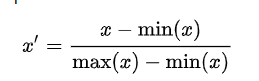

### Affichage des données avant normalisation

In [202]:
sns.pairplot(df_normalized);

In [203]:
df_normalized.round(2).T

In [204]:
df_normalized.describe().round(2)

In [205]:
# Appliquer la normalisation 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_normalized)

In [206]:
df_normalized = pd.DataFrame(df_normalized, columns = ['GDP per capita, PPP (current international $)', 'Internet users (per 100 people)', 'Personal computers (per 100 people)', 'Population, total', 'Population, ages 15-24, total'])

### Affichage des données après normalisation

In [207]:
sns.pairplot(df_normalized);

In [208]:
df_normalized.describe().round(2)

In [209]:
df_normalized['Country Name'] = df_Country_Name['Country Name']
df_normalized = df_normalized.set_index('Country Name')

In [210]:
df_normalized

### Création des scores

In [211]:
df_normalized = df_normalized.T
df_normalized

In [212]:
df_normalized.index

# Utiliser le rang

In [213]:
#df_rang  = df_rang.drop(['Position'], axis=0)

In [246]:
df_rang = df_normalized.copy()

In [247]:
# itertools pour un bouclage efficace 

import itertools

num_features=len(df_rang)

score_countries=dict.fromkeys(df_rang.columns, 0)

for weights in list(itertools.permutations(range(1,num_features+1))):

    weights=pd.Series(list(weights))

    score_each_feature_each_country=df_rang.rank(axis=1).reset_index(drop=True).mul(weights,axis=0)
    #print(score_each_feature_each_country)

    score_each_country=score_each_feature_each_country.sum(axis=0)
    #print(score_each_country)
    
    countries_sorted_by_score=score_each_country.sort_values(ascending=False).index
    #print(countries_sorted_by_score)
    
    #add score each contry 

    for idx, country in enumerate(countries_sorted_by_score):

        score_countries[country]=+idx

countries_final=list(dict(sorted(score_countries.items(), key=lambda item: item[1])).keys())

countries_final[:5]

In [216]:
#score_countries['Germany']

In [248]:
# total contries 
df_rang[countries_final[:5]]

In [250]:
(pd.DataFrame.from_dict(score_countries, orient='index').sort_values(0, axis=0)/120).T

In [251]:
# Delete after 
# Nouvelle df avec column position des pais com base dans le rang 
new_row = pd.DataFrame.from_dict(score_countries, orient='index').sort_values(0, axis=0).T 
df_rang = df_rang[countries_final].append(new_row, ignore_index = False)
df_rang.columns.name="Country Name"
#changement de le nom de la ligne
df_rang.rename(index={0:'Position'}, inplace=True)
df_rang.T

In [252]:
# # Nouvelle df avec column position des pais com base dans le rang 
# new_row = pd.DataFrame.from_dict(score_countries, orient='index').sort_values(0, axis=0).T 
# df_rang = df_rang.rank(axis=1)[countries_final].append(new_row, ignore_index = False)
# df_rang.columns.name="Country Name"
# #changement de le nom de la ligne
# df_rang.rename(index={0:'Position'}, inplace=True)
# df_rang.T

In [221]:
# #run to delete rows 
#df_rang = df_rang.drop(['Position'], axis=0)

In [222]:
# #run to delete rows 
#df_normalized = df_normalized.drop([0], axis=0)

In [253]:
%matplotlib inline

#plt.figure(figsize=(10,3))
sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(df_rang.loc[:,countries_final[:5]].T.reset_index(),
                 x_vars=df_rang.T, y_vars=['Country Name'],
                 height=12, aspect=0.30)
                
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=False,palette="flare_r", linewidth=2, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-10, 170), xlabel="Indicators Score", ylim=(5, -0.5), ylabel="Country Name")


# Use semantically meaningful titles for the columns
titles = ["GDP per capita" , "Internet users" , "Personal computers" , "Population, total" , "Population, ages 15-24", "Position"]

for ax, title in zip(g.axes.flat, titles):
    
        # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

g.axes[0,5].set_xlim(10,-1)
sns.despine(left=True, bottom=True)
%matplotlib inline

#plt.figure(figsize=(10,3))
sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(df_rang.loc[:,countries_final[:5]].T.reset_index(),
                 x_vars=df_rang.T, y_vars=['Country Name'],
                 height=12, aspect=0.30)
                
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=False,palette="flare_r", linewidth=2, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.3, 1.5), xlabel="Indicators Score", ylim=(5, -0.5), ylabel="Country Name")


# Use semantically meaningful titles for the columns
titles = ["GDP per capita" , "Internet users" , "Personal computers" , "Population, total" , "Population, ages 15-24", "Position"]

for ax, title in zip(g.axes.flat, titles):
    
        # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

g.axes[0,5].set_xlim(10,-1)
sns.despine(left=True, bottom=True)

# Utilisation de la valeur

In [224]:
#df_valeur = df_valeur.drop(['Position'], axis=0)

In [254]:
df_valeur = df_normalized.copy()

In [255]:
# itertools pour un bouclage efficace 

import itertools

num_features=len(df_valeur)

score_countries=dict.fromkeys(df_valeur.columns, 0)

for weights in list(itertools.permutations(range(1,num_features+1))):

    weights=pd.Series(list(weights))
    #print(weights)

    score_each_feature_each_country=df_valeur.reset_index(drop=True).mul(weights,axis=0)
    #print(score_each_feature_each_country)

    score_each_country=score_each_feature_each_country.sum(axis=0)
    #print(score_each_country)
    
    countries_sorted_by_score=score_each_country.sort_values(ascending=False).index
    #print(countries_sorted_by_score)

    
    #add score each contry 

    for idx, country in enumerate(countries_sorted_by_score):

        score_countries[country]+=idx
        #print(countries_sorted_by_score)

countries_final=list(dict(sorted(score_countries.items(), key=lambda item: item[1])).keys())

#countries_final[:5]

In [256]:
# vérifier le score des 10 meilleurs pays
df_valeur.loc[:,countries_final[:5]]

In [228]:
#delete after
#df_valeur.rank().loc[:,countries_final[:5]]

In [257]:
(pd.DataFrame.from_dict(score_countries, orient='index').sort_values(0, axis=0).T)

In [258]:
((pd.DataFrame.from_dict(score_countries, orient='index').rank()).sort_values(0, axis=0).T).round()

In [259]:
# Nouvelle df avec column position des pais com base dans le rang 
new_row = pd.DataFrame.from_dict(score_countries, orient='index').rank().sort_values(0, axis=0).T
df_valeur = df_valeur[countries_final].append(new_row, ignore_index = False)
df_valeur.columns.name="Country Name"
#changement de le nom de la ligne
df_valeur.rename(index={0:'Position'}, inplace=True)
df_valeur

In [232]:
# # Nouvelle df avec column position des pais com base dans le rang 
# new_row = pd.DataFrame.from_dict(score_countries, orient='index').rank().sort_values(0, axis=0).T
# df_valeur = df_valeur.rank(axis=1)[countries_final].append(new_row, ignore_index = False)
# df_valeur.columns.name="Country Name"
# #changement de le nom de la ligne
# df_valeur.rename(index={0:'Position'}, inplace=True)
# df_valeur.T

In [260]:
%matplotlib inline

#plt.figure(figsize=(10,3))
sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(df_valeur.loc[:,countries_final[:5]].T.reset_index(),
                 x_vars=df_valeur.T, y_vars=['Country Name'],
                 height=12, aspect=0.30)
                
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=False,palette="flare_r", linewidth=2, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.3, 1.5), xlabel="Indicators Score", ylim=(5, -0.5), ylabel="Country Name")

# Use semantically meaningful titles for the columns
titles = ["GDP per capita" , "Internet users" , "Personal computers" , "Population, total" , "Population, ages 15-24", "Position"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

g.axes[0,5].set_xlim(10,-1)
sns.despine(left=True, bottom=True)

In [261]:
df_normalized['Average Country']=df_normalized.mean(axis=1)

In [262]:
for idx, row in df_normalized.iterrows():
    f = plt.figure(figsize=(20,7))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    plt.suptitle('Feature: ' + idx)
    row.rank()[countries_final[:5]].plot(kind='bar', ax=ax1)
    ax1.set_title('Rank according to other countries. Max: ' + str(len(df_normalized.columns)))
    ax1.axhline(len(df_normalized.columns)/2, color='r',label='Average Country',linestyle='--')
    ax1.set_ylim([0,len(df_normalized.columns)])
    
    
    df_normalized.loc[idx,countries_final[:5]].plot(kind='bar', ax=ax2)
    ax2.set_title('Value of feature')
    ax2.axhline(row['Average Country'], color='r',label='Average Country',linestyle='--')
    ax2.legend()
    ax1.set_xticklabels(countries_final[:5], rotation = 75)
    ax2.set_xticklabels(countries_final[:5], rotation = 75)
    plt.show()
    print('')
    print('')